In [1]:
import sys
import os
sys.path.append("../..")

from progressbar import progressbar as pbar
from omegaconf import OmegaConf
from sdofm.datasets.SDOML import SDOMLDataModule, SDOMLDataset
from sdofm.datasets.RandomIntervalSDOML import RandomIntervalSDOMLDataset, RandomIntervalSDOMLDataModule 
from sdofm.models import dimming
from rlxutils import subplots
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sdofm.utils import stonyhurst_to_patch_index
from progressbar import progressbar as pbar
from sdofm.constants import ALL_COMPONENTS, ALL_WAVELENGTHS, ALL_IONS
from rlxutils import ElapsedTimes
import torch
from torch import nn
from sdofm.models import unet
import torch.nn.functional as F

from importlib import reload
reload(dimming)

<module 'sdofm.models.dimming' from '/home/rlx/SDO-FM/notebooks/downstream-dimming/../../sdofm/models/dimming.py'>

In [2]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(100).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        

In [3]:
cfg = OmegaConf.load("../../experiments/default.yaml")

In [61]:
year = '2014'
year_end = year
year_start = '2011'
data_module = RandomIntervalSDOMLDataModule(
    # hmi_path=os.path.join(
    #     self.cfg.data.sdoml.base_directory, self.cfg.data.sdoml.sub_directory.hmi
    # ),
    hmi_path=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.hmi,
    ),
    aia_path = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.aia,
    ),    
    eve_path = None,
    components  = cfg.data.sdoml.components,
    wavelengths = cfg.data.sdoml.wavelengths,
    ions        = cfg.data.sdoml.ions,
    frequency   = cfg.data.sdoml.frequency,
    batch_size  = 8,
    num_workers = 10,
    num_frames  = 1,
    blosc_cache = "/home/rlx/blosc_cache",
    start_date = f'{year_start}-01-01',
    end_date   = f'{year_end}-12-31',
    dim = 'single',
    sampling_period = '10days',
    val_months  = cfg.data.month_splits.val,
    test_months = cfg.data.month_splits.test,
    holdout_months = cfg.data.month_splits.holdout,
    cache_dir = os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
)
data_module.setup()
lossh_models = {}

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_HMI_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_HMI_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [62]:
pretrained_unet = torch.load("../fm-brightspots/unetmodel_12ch_1classes_bilinear_sizefactor4.ckpt").cuda()

## build dataloader objects

In [63]:
dltrain = data_module.train_dataloader()
dlval   = data_module.val_dataloader()
val_iter = iter(dlval)
len(dltrain), len(dlval)

(14724, 1314)

In [7]:
b = next(val_iter)
b.keys()

dict_keys(['timestamps', 'image_stack', 'dimmed_image_stack', 'dim_factor'])

In [8]:
b['dim_factor'].shape

torch.Size([8, 1])

In [9]:
b['dimmed_image_stack'].shape

torch.Size([8, 12, 1, 512, 512])

## test model

In [13]:
reload(dimming)
output_size = 1 if data_module.dim=='single' else 12
fc_layers_size = [128,64,16]

model = dimming.DimmingEstimator(pretrained_unet=None, output_size = output_size).cuda()
model_name_prefix = "scratch"

#model = dimming.DimmingEstimator(pretrained_unet=pretrained_unet, output_size = output_size).cuda()
#model_name_prefix = "unet_pretrained_full"

#model = dimming.DimmingEstimator(pretrained_unet=pretrained_unet, output_size = output_size).cuda()
#model_name_prefix = "unet_pretrained_fconly"

loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )
#loss_fn = lambda a,b: torch.mean((a-b)**2 )

psize = [np.prod(i.shape) for i in model.unet.encoder_layers.parameters()]
print ("encoder parameters        ", sum(psize))

psize = [np.prod(i.shape) for i in model.fc_layers.parameters()]
print ("fc_layers parameters      ", sum(psize))


encoder parameters         590720
fc_layers parameters       4220257


In [16]:
batch = b
dimmed_image_stack = batch['dimmed_image_stack'][:,:,0,:,:].type(torch.FloatTensor).cuda()
actual_dimming = batch['dim_factor'].cuda()
pred_dimming = model(dimmed_image_stack)

In [17]:
pred_dimming.shape, actual_dimming.shape

(torch.Size([8, 1]), torch.Size([8, 1]))

## training loop

In [64]:
loss_fn = lambda a,b: torch.sqrt( torch.mean((a-b)**2 ) )

def train_loop(model, optimizer, dataloader, num_epochs=3):
    lossh = []
    for epoch in range(num_epochs):
        t0 = datetime.now() 

        try:
            for step, batch in enumerate(dltrain):
                # extract data from batch
                dimmed_image_stack = batch['dimmed_image_stack'][:,:,0,:,:].type(torch.FloatTensor).cuda()
                actual_dimming = batch['dim_factor'].cuda()

                # forward
                pred_dimming = model(dimmed_image_stack)

                # loss
                loss = loss_fn(actual_dimming,pred_dimming)

                # backpropage and optimzier uipdate
                loss.backward()
                optimizer.step()

                # cosmetics
                lossn = loss.detach().cpu().numpy()
                lossh.append(lossn)

                psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in model.parameters()])    
                lossm = np.mean(lossh[-100:])
                epoch_time = (datetime.now() - t0).seconds
                print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} params {psummary:.7f} epoch_time {epoch_time} secs", end="\r")

        except KeyboardInterrupt:
            print ("\nkeyboard interrupt")
            break
        except Exception as e:
            print (e)
            pass
        print()
    return lossh

def ploth(h, data_module=None, name='loss', ylim=None, ax=None, color='blue'):
    
    if data_module is not None:
        bs = data_module.batch_size
        nchips = len(data_module.train_ds)
        steps_per_epoch = nchips // bs
        for i in range(0,len(h), steps_per_epoch):
            plt.axvline(i, ls='--', color='gray', alpha=.5)

    lossp = pd.DataFrame(h, columns=['signal'])
    lossp[f'smoothed'] = lossp['signal'].rolling(500).mean()
    plt.plot(lossp['signal'], color=color, alpha=.1)
    plt.plot(lossp[f'smoothed'], color=color, alpha=1, label=name)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
    return lossp

In [65]:
confs = {}
output_size = 1 if data_module.dim=='single' else 12
fc_layers_size = [2048, 1024, 512, 1024, 256, 1024, 128, 64]
learning_rate = 1e-5

model= dimming.DimmingEstimator(pretrained_unet=None, output_size=output_size, fc_layers_size=fc_layers_size).cuda()
confs['scratch'] = {'model': model,
                  'optimizer': torch.optim.Adam(model.parameters(), lr=learning_rate)}

model= dimming.DimmingEstimator(pretrained_unet=pretrained_unet, output_size=output_size, fc_layers_size=fc_layers_size).cuda()
confs['unet_pretrained_full'] = {'model': model,
                  'optimizer': torch.optim.Adam(model.parameters(), lr=learning_rate)}

model= dimming.DimmingEstimator(pretrained_unet=pretrained_unet, output_size=output_size, fc_layers_size=fc_layers_size).cuda()
confs['unet_pretrained_fconly'] = {'model': model,
                  'optimizer': torch.optim.Adam(model.fc_layers.parameters(), lr=learning_rate)}



In [ ]:
lossh_models= {}
num_epochs = 6
for k in ['scratch']: # confs.keys():
    print ("-----", k, "------")
    model = confs[k]['model']
    optimizer = confs[k]['optimizer']
    dataloader = dltrain = data_module.train_dataloader()
    lossh_models[k] = train_loop(model, optimizer, dataloader, num_epochs=num_epochs)

----- scratch ------


In [48]:
torch.save(confs['scratch']['model'], "unet_dim_scratch.ckpt")

In [44]:
lossh_models.keys()

dict_keys(['scratch', 'unet_pretrained_full', 'unet_pretrained_fconly'])

(0.0, 0.2)

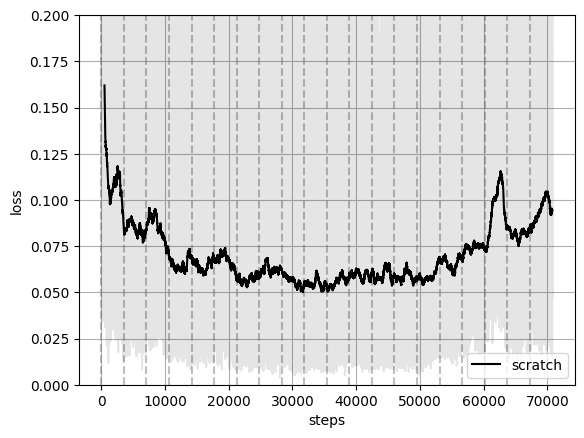

In [58]:
for name,color in zip( ('scratch',), ('black',)):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()
plt.ylim(0,0.2)

(0.0, 0.2)

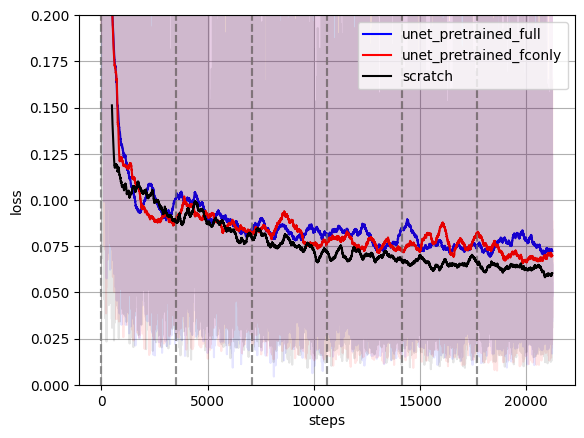

In [51]:
for name,color in zip( ('unet_pretrained_full', 'unet_pretrained_fconly', 'scratch'), ('blue', 'red', 'black')):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()
plt.ylim(0,0.2)

(0.0, 0.2)

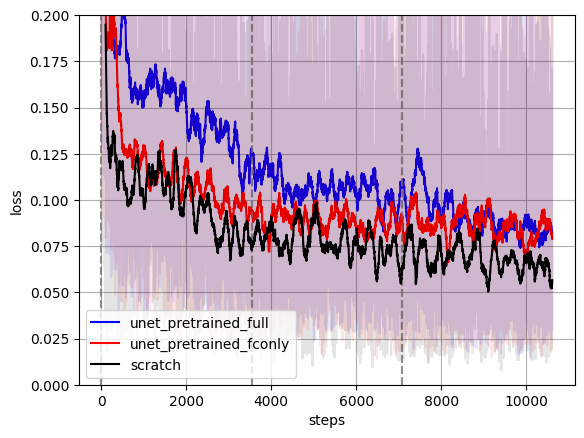

In [40]:
for name,color in zip( ('unet_pretrained_full', 'unet_pretrained_fconly', 'scratch'), ('blue', 'red', 'black')):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()
plt.ylim(0,0.2)

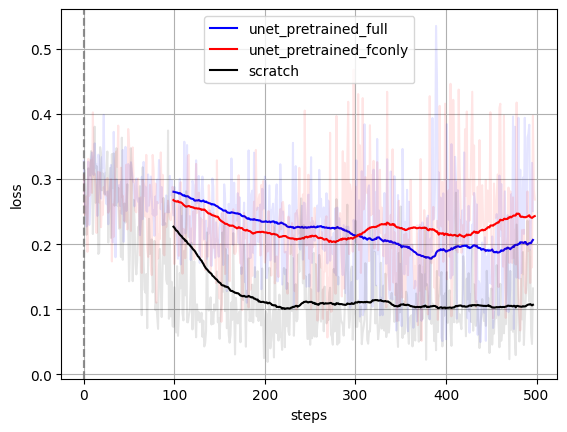

In [30]:
for name,color in zip( ('unet_pretrained_full', 'unet_pretrained_fconly', 'scratch'), ('blue', 'red', 'black')):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()

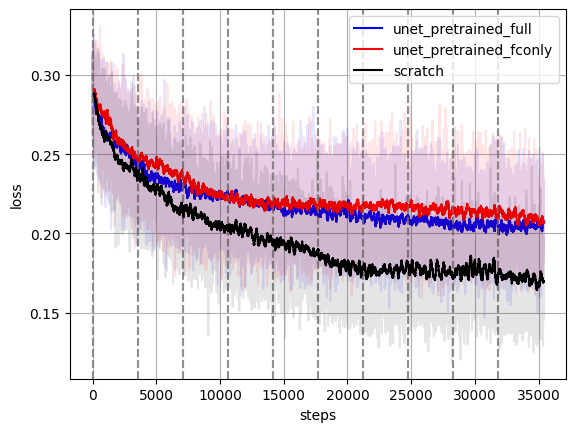

In [138]:
for name,color in zip( ('unet_pretrained_full', 'unet_pretrained_fconly', 'scratch'), ('blue', 'red', 'black')):
    pp = ploth(lossh_models[name], data_module = data_module, name=name, color=color)
plt.legend()

In [117]:
bs = data_module.batch_size
nchips = len(data_module.train_ds)
steps_per_epoch = nchips // bs

In [155]:
print ("train method              rmse")
for k in lossh_models.keys():
    rmse = np.mean(lossh_models[k][-steps_per_epoch])
    print(f"{k:25s} {rmse:.3f}" )


train method              rmse
scratch                   0.274
unet_pretrained_full      0.342
unet_pretrained_fconly    0.295


In [146]:
model

DimmingEstimator(
  (unet): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(32, 32, k